# Obtenir dataset pel·lícules

En aquest codi anem a obtenir un dataset de pel·lícules.
Realitzarem els següents passos:
- Carregar llibreries.
- Realitzar web scraping sobre la web https://www.themoviedb.org/movie/
- Capturar el llistat de totes les pel·lícules i obtenir els enllaços
- Accedir a cada pàgina de la pel·lícula i agafar les dades
- Tractar aquestes dades i guardar-les en un dataset.
- Visualitzar el dataset per veure si s'ha creat correctament.

### Carregar llibreries

In [1]:
from selenium.webdriver.chrome.options import Options 
from selenium import webdriver

from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys

from bs4 import BeautifulSoup
import time
import random
import csv
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

### Iniciar consulta a la web

In [21]:
url_base = "https://www.themoviedb.org"

options = Options()
# Afegirem l'opció --headless per a que s'execute en segon planol i no obriga el navegador
options.add_argument("--headless")

# Buscarem les pelicules en la versio en espanyol de la web
options.add_argument("--lang=es-ES");

driver = webdriver.Chrome("chromedriver.exe", options=options)
driver.get(url_base+"/movie")

### Aplicar filtres

Si volem, podem aplicar certs filtres per a l'obtenció d'un tipus de pel·lícules en concret

In [22]:
# Obrir les pestanyes a l'esquerra per tal de fer la selecció dels filtres
for item in driver.find_elements_by_xpath(".//*[@class='filter_panel card closed']"):
    ActionChains(driver).move_to_element(item).click().perform()
time.sleep(1)

In [24]:
# Filtrar per gènere - Fem l'exemple amb el gènere 'Acción'
accio = driver.find_element_by_link_text("Acción")
driver.execute_script("arguments[0].click();", accio)

In [91]:
# Filtrar per plataforma de streaming - Fem l'exemple amb Netflix
Netflix = driver.find_element_by_xpath("//a[@title='Netflix']")
driver.execute_script("arguments[0].click();", Netflix)

Creem una funció per seleccionar una dade en el calendari popup

In [17]:
# Funció per obtindre el mes en numero
def get_mes_numero(mes):
    mesos = ["enero", "febrero", "marzo", "abril", "mayo", "junio", "julio", "agosto", "septiembre", "octubre", "noviembre", "diciembre"]
    return mesos.index(mes) + 1

# Funció per buscar una dada en el calendari kendoDatePicker de la web
def clic_data_calendari(driver_selenium, id_container, dia_objectiu, mes_objectiu, any_objectiu, posicio_calendari):
    
    # Fer clic per obrir el calendari
    dada_input = driver.find_element_by_id(id_container)
    next_sibling = driver.execute_script("return arguments[0].nextElementSibling", dada_input)
    driver.execute_script("arguments[0].click();", next_sibling)
    time.sleep(1)

    # Obtindre els elements de següent i anterior mes
    next_link = driver.find_elements_by_class_name("k-next-view")[posicio_calendari]
    prev_link = driver.find_elements_by_class_name("k-prev-view")[posicio_calendari]

    # Obtenim 'mes any' que será el indicador que estem en la vista adecuada del calendari
    mes_any_objectiu = mes_objectiu + ' ' + any_objectiu
    mes_objectiu_num = get_mes_numero(mes_objectiu)
    
    # Calculem les variables actuals del calendari de la web
    mes_any_calendari = driver.find_elements_by_class_name("k-title")[posicio_calendari].get_attribute("innerHTML")
    mes_calendari = mes_any_calendari.split()[0]
    mes_calendari_num = get_mes_numero(mes_calendari)
    any_calendari = mes_any_calendari.split()[1]
    
    # Anem desplazant el calendari fins trobar el mes corresponent
    while(mes_any_calendari != mes_any_objectiu):
        if(any_calendari == any_objectiu):
            if(mes_calendari_num > mes_objectiu_num):
                driver.execute_script("arguments[0].click();", prev_link)
                time.sleep(0.5)
            else:
                driver.execute_script("arguments[0].click();", next_link)
                time.sleep(0.5)
        elif(int(any_calendari) > int(any_objectiu)):
            clics_mesos = (int(any_calendari) - int(any_objectiu))*12
            for i in range(clics_mesos):
                driver.execute_script("arguments[0].click();", prev_link)
                time.sleep(0.5)
        else:
            clics_mesos = (int(any_objectiu) - int(any_calendari))*12
            for i in range(clics_mesos):
                driver.execute_script("arguments[0].click();", next_link)
                time.sleep(0.5)
        
        # Actualitzem els valors del calendari        
        mes_any_calendari = driver.find_elements_by_class_name("k-title")[posicio_calendari].get_attribute("innerHTML")
        mes_calendari = mes_any_calendari.split()[0]
        mes_calendari_num = get_mes_numero(mes_calendari)
        any_calendari = mes_any_calendari.split()[1]
      
    if(mes_any_calendari == mes_any_objectiu):
        dia_container = driver.find_elements_by_link_text(dia_objectiu)[-1]
        driver.execute_script("arguments[0].click();", dia_container)

In [23]:
# Clic en dada 'desde'
clic_data_calendari(driver, 'release_date_gte', '1', 'enero', '2000', 0)
time.sleep(1)

# Clic en dada 'hasta'
clic_data_calendari(driver, 'release_date_lte', '1', 'enero', '2005', 1)
time.sleep(1)

In [25]:
# Realitzar búsqueda
time.sleep(1)
buscar = driver.find_element_by_link_text("Buscar")
driver.execute_script("arguments[0].click();", buscar)
time.sleep(1)

### Obtenir les pel·lícules del llistat.

Utilitzarem Selenium per a interactuar amb la web

Primer farem clic en "Mostrar más" i després anirem carregant les dades mitjançant l'scroll.

Definim un maxim de vegades que farem scroll

In [26]:
# Fer click en "Mostrar más"
element = driver.find_element_by_link_text("Mostrar más") 
driver.execute_script("arguments[0].click();", element)
time.sleep(1)

# Fer scroll per capturar dades conforme es van carregant
url_single_movies = []
max_iterations = 0
iter=1
while max_iterations < 2500:
    scroll_height = driver.execute_script("return document.documentElement.scrollHeight")
    # A cada iteració anem augmentant l'scroll
    height=4200*iter
    driver.execute_script("window.scrollTo(0, " + str(height) + ");")
    # Si hem arribat al final de la pàgina, parem el bucle
    if height > scroll_height:
        print('End of page')
        break
    time.sleep(random.randint(1, 2))
    max_iterations+=1
    iter+=1

body = driver.execute_script("return document.body")
source = body.get_attribute('innerHTML') 

# Agafem les pelicules
soup = BeautifulSoup(source, "html.parser")
movies = soup.find_all("div", {"class": "card style_1"})

print(len(movies))

End of page
1560


### Obtenir informació individual de cada pel·lícula

Primer recorrerem l'HTML obtingut i capturarem els enllaços a la fitxa de cada pel·lícula

In [27]:
# Capturar els enllaços
for movie in movies:
    title = movie.h2.a["href"] 
    url_single_movies.append(title)

Creem algunes funcions auxiliars que ens ajudaran a tractar les dades de la fitxa. A més, si en un futur l'estructura de la pàgina que estem fent web scraping canvia, podem modificar més fàcilment la part que correspongui.

Si no existeix algun valor retornarem "?" en tots els camps excepte amb "Puntuación" que retornarem un -1.

In [28]:
# Get Título
def get_titulo(movie):
    try:
        return movie.find("h2").a.contents[0]
    except AttributeError:
        return "?"

# Get Título original
def get_titulo_otiginal(movie):
    try:
        titulo_container = movie.find("p", {"class": "wrap"}).get_text()
        return titulo_container.split("Título original", 1)[1]
    except AttributeError:
        return "?"

# Get Idioma original
def get_idioma_original(movie):
    try:
        idioma_container = movie.get_text().split("Idioma original", 1)
        return idioma_container[1].split("\n", 1)[0]
    except AttributeError:
        return "?"

# Get Duración
def get_duracion(movie):
    try:
        return movie.find("span", {"class":"runtime"}).text.strip()
    except AttributeError:
        return "?"

# Get Géneros
def get_generos(movie):
    try:
        generos_container = movie.find("span", {"class":"genres"}).find_all("a")
        generos_container = [generos_container[genre].text for genre in range(len(generos_container))]
        return ", ".join(generos_container)
    except AttributeError:
        return "?"
    
# Get Directores
def get_directores(movie):
    try:
        directores = []
        people_container = movie.select("ol.people.no_image li")
        for people in people_container:
            cargo = people.find("p", {"class":"character"}).text
            if "Director" in cargo:
                directores.append(people.find("p").text)
        return ", ".join(directores)
    except AttributeError:
        return "?"

# Get Sinopsis
def get_sinopsis(movie):
    try:
        return movie.find_all("div",{"class": "overview"})[0].text.strip()
    except AttributeError:
        return "?"

# Get Fecha de estreno
def get_fecha_estreno(movie):
    try:
        return movie.find("span", {"class": "release"}).get_text().strip().split(" ", 1)[0]
    except AttributeError:
        return "?"

# Get Clasificación por edad
def get_clasificacion_edad(movie):
    try:
        return movie.find("span", {"class": "certification"}).get_text().strip()
    except AttributeError:
        return "?"

# Get Imagen cartel
def get_img_cartel(movie):
    try:
        return movie.find("img").attrs['src']
    except AttributeError:
        return "?"

# Get Puntiación
def get_puntuacion(movie):
    try:
        return list(movie.find("span",{"class":"icon"}).attrs.values())[0][1][-2:]
    except AttributeError:
        return -1
    
# Get Streaming
def get_streaming(movie):
    try:
        streaming = movie.find("div", {"class":"provider"}).find("img").attrs['alt']
        streaming = streaming.split(" en ")
        return streaming[-1]
    except AttributeError:
        return "?"

Obrim el fitxer csv on guardarem les dades obtingudes i escrivim la primera línea que sera el nom de les columnes

In [29]:
data_file = open('dataset_peliculas.csv', 'w', newline='', encoding='utf-8')
csv_writer = csv.writer(data_file, delimiter=";") 
csv_writer.writerow(["Título","Título original","Idioma original","Duración","Géneros","Directores","Sinopsis","Fecha de estreno","Clasificación por edad","Imagen cartel","Puntuación", "Streaming"]) 

152

Accedim a la fitxa de cada pel·lícula i anem capturant les dades i guardant-les en el fitxer csv

In [30]:
# Recorrem els enllaços obtinguts i anem obtinguent informació de cada pel·lícula
for url_movie in url_single_movies:
    driver.get(url_base+url_movie)
    body = driver.execute_script("return document.body")
    source = body.get_attribute('innerHTML') 
    soup = BeautifulSoup(source, "html.parser")

    # Contenidors de la informació que volem capturar
    poster_wrapper = soup.find("div", {"class": "poster_wrapper"})
    header_wrapper = soup.find("div", {"class": "header_poster_wrapper"})
    column_wrapper = soup.find("section", {"class": "left_column"})

    movie =  [
        get_titulo(header_wrapper), # Título
        get_titulo_otiginal(column_wrapper), # Título original
        get_idioma_original(column_wrapper), # Idioma original
        get_duracion(header_wrapper), # Duración
        get_generos(header_wrapper), # Géneros        
        get_directores(header_wrapper), # Directores
        get_sinopsis(header_wrapper), # Sinopsis
        get_fecha_estreno(header_wrapper), # Fecha de estreno
        get_clasificacion_edad(header_wrapper), # Clasificación por edad
        url_base+get_img_cartel(poster_wrapper), # Imagen cartel
        get_puntuacion(header_wrapper), # Puntuación 
        get_streaming(poster_wrapper) # Streaming
    ]

    csv_writer.writerow(movie)
    
    # Deixem entre 1 i 2 segons de pausa entre cada iteració per no saturar la web
    time.sleep(random.randint(1, 2))

Tanquem el fitxer csv

In [31]:
data_file.close()

Tanquem el driver de selenium

In [32]:
driver.close()

### Comprovació final

Per comprovar que s'han guardat correctament, carreguem el csv en una variable i vegem els primers registres

In [33]:
df_movies = pd.read_csv("dataset_peliculas.csv", sep=";", encoding="utf-8")
df_movies.head(10)

,Título,Título original,Idioma original,Duración,Géneros,Directores,Sinopsis,Fecha de estreno,Clasificación por edad,Imagen cartel,Puntuación,Streaming
0,Godzilla,?,Inglés,2h 18m,"Ciencia ficción, Acción, Suspense",Roland Emmerich,Las pruebas nucleares realizadas por los franc...,28/8/1998,PG-13,https://www.themoviedb.org/t/p/w300_and_h450_b...,56,Netflix
1,Dragon Ball Z: Estalla el duelo,ドラゴンボールＺ 燃え尽きろ!!熱戦・烈戦・超激戦,Japonés,1h 12m,"Animación, Ciencia ficción, Acción",Shigeyasu Yamauchi,"Un desconocido saiyan, Paragus, llega a la Tie...",6/3/1993,PG,https://www.themoviedb.org/t/p/w300_and_h450_b...,72,?
2,Dragon Ball Z: Los mejores rivales,Doragon bôru Z 5: Tobikkiri no saikyô tai saikyô,Japonés,1h,"Acción, Animación, Ciencia ficción",Mitsuo Hashimoto,"Tras enterarse de la muerte de Freezer, Cooler...",20/7/1991,PG,https://www.themoviedb.org/t/p/w300_and_h450_b...,68,?
3,Dragon Ball Z: El más fuerte del mundo,ドラゴンボールZ この世で一番強いヤツ,Japonés,45m,"Acción, Animación, Ciencia ficción",Daisuke Nishio,"Shen Long es invocado por el Dr. Kochin, el cu...",26/5/1998,PG,https://www.themoviedb.org/t/p/w300_and_h450_b...,63,?
4,Dragon Ball Z: Los guerreros de plata,ドラゴンボールZ 銀河ギリギリ!! ぶっちぎりの凄い奴,Japonés,43m,"Acción, Animación, Ciencia ficción",Yoshihiro Ueda,El rico Gyosan Money organiza un nuevo torneo ...,10/7/1993,12,https://www.themoviedb.org/t/p/w300_and_h450_b...,69,?
5,Dragon Ball Z: Guerreros de fuerza ilimitada,ドラゴンボールZ 激突!!100億パワーの戦士たち,Japonés,50m,"Acción, Animación, Ciencia ficción",Daisuke Nishio,"Cuando Dende, el nuevo kamisama, se entera de ...",13/8/2002,NR,https://www.themoviedb.org/t/p/w300_and_h450_b...,67,?
6,Dragon Ball Z: Los tres grandes Super Saiyans,ドラゴンボールＺ 極限バトル！三大超サイヤ人,Japonés,46m,"Acción, Animación, Ciencia ficción",Daisuke Nishio,Décima película basada en el manga/anime de Ak...,11/7/1992,12,https://www.themoviedb.org/t/p/w300_and_h450_b...,66,?
7,Spy Kids,?,Inglés,1h 28m,"Acción, Comedia, Familia, Aventura",Robert Rodriguez,Cuando el matrimonio Cortez -aparentes padres ...,18/3/2001,PG,https://www.themoviedb.org/t/p/w300_and_h450_b...,58,fuboTV
8,Dragon Ball Z: La super batalla,ドラゴンボールZ 地球まるごと超決戦,Japonés,1h,"Acción, Animación, Ciencia ficción",Daisuke Nishio,Sexta película basada en el manga/anime de Aki...,7/6/1990,PG,https://www.themoviedb.org/t/p/w300_and_h450_b...,65,?
9,El señor de los anillos: La comunidad del anillo,The Lord of the Rings: The Fellowship of the ...,Inglés,2h 59m,"Aventura, Fantasía, Acción",Peter Jackson,"En la Tierra Media, el Señor Oscuro Saurón cre...",19/12/2001,12,https://www.themoviedb.org/t/p/w300_and_h450_b...,83,Movistar Plus


In [34]:
df_movies.shape[0]

1560

<BarContainer object of 19 artists>

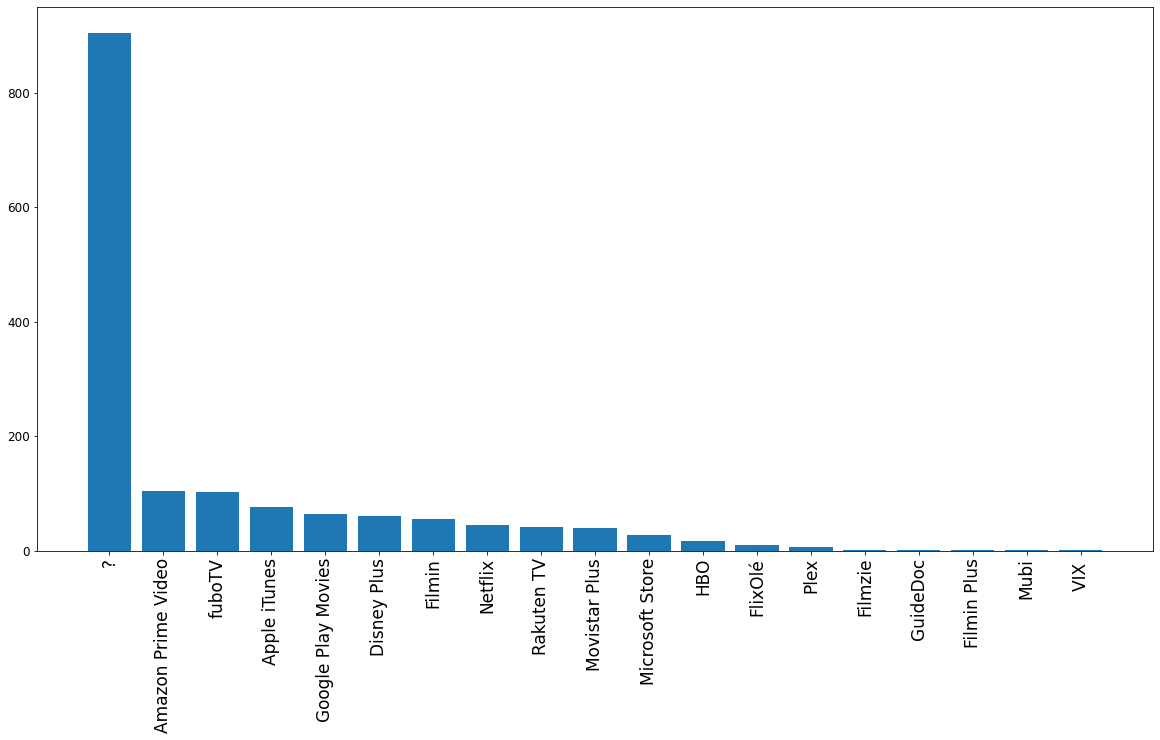

In [35]:
params = {'xtick.labelsize': 17, 'ytick.labelsize': 12}
mpl.rcParams.update(params)

servicios_streaming = pd.value_counts(df_movies["Streaming"])

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.bar(servicios_streaming.index, servicios_streaming)